<a href="https://colab.research.google.com/github/Flaviasoz/social-media-productivity/blob/main/modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 3: Modelagem e Validação

**Objetivo:** Construir e avaliar modelos preditivos  
**Dataset:** processed_data.csv  
**Autor:** Flávia Souza e Vinicius Loeblein  

## 1. Configuração Inicial

In [109]:
!pip install weasyprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import warnings
import os
import requests
from io import StringIO
import matplotlib.ticker as mtick
from weasyprint import HTML
import datetime
from google.colab import files


warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
os.makedirs("imgs_temp", exist_ok=True)

## 2. Carregamento dos Dados

In [110]:
# Cria diretórios necessários
os.makedirs("../data", exist_ok=True)
os.makedirs("../models", exist_ok=True)
os.makedirs("../reports/figures", exist_ok=True)

def load_dataset():
    """Carrega o dataset com fallback para múltiplas fontes"""
    # 1. Tentativa: GitHub
    github_url = "https://raw.githubusercontent.com/Flaviasoz/social-media-productivity/main/data/processed_data.csv"
    try:
        response = requests.get(github_url)
        response.raise_for_status()
        df = pd.read_csv(StringIO(response.text))
        print("✅ Dataset carregado do GitHub com sucesso!")

        # Salva localmente para próximas execuções
        df.to_csv('../data/processed_data.csv', index=False)
        return df
    except Exception as e:
        print(f"⚠️ Não foi possível carregar do GitHub: {str(e)}")

    # 2. Tentativa: Arquivos locais
    local_paths = [
        '../data/processed_data.csv',  # Path relativo padrão
        'social-media-productivity/data/processed_data.csv',  # Possível estrutura do repositório
        'processed_data.csv'  # Na raiz
    ]

    for path in local_paths:
        try:
            if os.path.exists(path):
                df = pd.read_csv(path)
                print(f"✅ Dataset carregado localmente de: {path}")
                return df
        except Exception as e:
            print(f"⚠️ Erro ao carregar {path}: {str(e)}")

    # 3. Tentativa: Upload manual
    print("\n🔍 Arquivo não encontrado nos locais padrão. Opções disponíveis:")
    print("1. Execute o notebook 1_data_cleaning.ipynb para gerar os dados")
    print("2. Coloque o arquivo processed_data.csv em uma das pastas:")
    print("   - ../data/")
    print("   - social-media-productivity/data/")
    print("   - Diretório raiz do projeto")
    print("3. Descomente a linha abaixo para upload manual")

    # Descomente se precisar fazer upload manual
    # df = upload_manually()
    # if df is not None:
    #     return df

    raise FileNotFoundError("Não foi possível carregar o dataset. Verifique as mensagens acima.")

def upload_manually():
    """Função para upload manual do arquivo"""
    try:
        from google.colab import files
        print("\n📤 Executando no Google Colab - faça o upload do arquivo:")
        uploaded = files.upload()
        for fn in uploaded.keys():
            df = pd.read_csv(fn)
            print(f"✅ Arquivo {fn} carregado com sucesso!")
            return df
    except:
        try:
            from tkinter import Tk, filedialog
            print("\n📂 Selecione o arquivo manualmente:")
            root = Tk()
            root.withdraw()
            file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
            if file_path:
                df = pd.read_csv(file_path)
                print(f"✅ Arquivo {file_path} carregado com sucesso!")
                return df
        except Exception as e:
            print(f"❌ Erro ao carregar arquivo: {str(e)}")
    return None

# Carrega o dataset
print("\n🔍 Buscando dataset...")
df = load_dataset()

# Exibe informações básicas
print(f"\n📊 Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas")
print("\n📋 Primeiras linhas:")
display(df.head(3))

# Verifica colunas disponíveis
print("\n🗂 Colunas disponíveis:")
print(df.columns.tolist())


🔍 Buscando dataset...
✅ Dataset carregado do GitHub com sucesso!

📊 Dataset carregado com 29860 linhas e 20 colunas

📋 Primeiras linhas:


,age,gender,job_type,daily_social_media_time,social_platform_preference,number_of_notifications,work_hours_per_day,perceived_productivity_score,actual_productivity_score,stress_level,sleep_hours,screen_time_before_sleep,breaks_during_work,uses_focus_apps,has_digital_wellbeing_enabled,coffee_consumption_per_day,days_feeling_burnout_per_month,weekly_offline_hours,job_satisfaction_score,uso_categoria
0,56,Male,Unemployed,4.180940,Facebook,61,6.753558,8.040464,7.291555,4.0,5.116546,0.419102,8,False,False,4,11,21.927072,6.336688,alto
1,46,Male,Health,3.249603,Twitter,59,9.169296,5.063368,5.165093,7.0,5.103897,0.671519,7,True,True,2,25,0.000000,3.412427,moderado
2,32,Male,Finance,3.113418,Twitter,57,7.910952,3.861762,3.474053,4.0,8.583222,0.624378,0,True,False,3,17,10.322044,2.474944,moderado



🗂 Colunas disponíveis:
['age', 'gender', 'job_type', 'daily_social_media_time', 'social_platform_preference', 'number_of_notifications', 'work_hours_per_day', 'perceived_productivity_score', 'actual_productivity_score', 'stress_level', 'sleep_hours', 'screen_time_before_sleep', 'breaks_during_work', 'uses_focus_apps', 'has_digital_wellbeing_enabled', 'coffee_consumption_per_day', 'days_feeling_burnout_per_month', 'weekly_offline_hours', 'job_satisfaction_score', 'uso_categoria']


## 3. Pré-processamento Final

In [111]:
features = ['daily_social_media_time', 'sleep_hours', 'age', 'stress_level']

# Seleção das features e da variável alvo
X = df[features].copy()
y = df['actual_productivity_score']

# Tratamento de valores faltantes nas features
X.fillna(X.mean(), inplace=True)
X = pd.get_dummies(X, columns=['age'], drop_first=True)

# Divisão treino-teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y.loc[X.index], test_size=0.2, random_state=42
)

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Modelagem

### 4.1 Modelo Baseline (Média)

In [112]:
# Previsão baseline: sempre a média do y_train
baseline_value = y_train.mean()
baseline_pred = np.full(shape=len(y_test), fill_value=baseline_value)

# Avaliação do baseline
mae_baseline = mean_absolute_error(y_test, baseline_pred)
r2_baseline = r2_score(y_test, baseline_pred)

print("Modelo Baseline (média):")
print(f"MAE Baseline: {mae_baseline:.2f}")
print(f"R² Baseline: {r2_baseline:.2f}")

Modelo Baseline (média):
MAE Baseline: 1.49
R² Baseline: -0.00


### 4.2 Regressão Linear

In [113]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

mae_lr = mean_absolute_error(y_test, lr_pred)
r2_lr = r2_score(y_test, lr_pred)

print("Regressão Linear:")
print(f"MAE Regressão Linear: {mae_lr:.2f}")
print(f"R² Regressão Linear: {r2_lr:.2f}")

Regressão Linear:
MAE Regressão Linear: 1.49
R² Regressão Linear: -0.00


### 4.3 Random Forest

In [114]:
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)

mae_rf = mean_absolute_error(y_test, rf_pred)
r2_rf = r2_score(y_test, rf_pred)

print("Random Forest:")
print(f"MAE Random Forest: {mae_rf:.2f}")
print(f"R² Random Forest: {r2_rf:.2f}")

Random Forest:
MAE Random Forest: 1.49
R² Random Forest: -0.00


### 4.4 XGBoost

In [115]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

mae_xgb = mean_absolute_error(y_test, xgb_pred)
r2_xgb = r2_score(y_test, xgb_pred)

print("XGBoost:")
print(f"MAE XGBoost: {mae_xgb:.2f}")
print(f"R² XGBoost: {r2_xgb:.2f}")

XGBoost:
MAE XGBoost: 1.50
R² XGBoost: -0.01


## 5. Comparação de Modelos

In [116]:
results = pd.DataFrame({
    'Modelo': ['Baseline (Média)', 'Regressão Linear', 'Random Forest', 'XGBoost'],
    'MAE': [mae_baseline, mae_lr, mae_rf, mae_xgb],
    'R²': [r2_baseline, r2_lr, r2_rf, r2_xgb]
})
results_sorted = results.sort_values(by='MAE').reset_index(drop=True)

print("Comparação de Modelos (ordenado por MAE):")
display(results_sorted.style.background_gradient(cmap='viridis'))

Comparação de Modelos (ordenado por MAE):


,Modelo,MAE,R²
0,Baseline (Média),1.485410,-0.000132
1,Random Forest,1.487256,-0.000293
2,Regressão Linear,1.492603,-0.003264
3,XGBoost,1.501796,-0.011731


## 6. Interpretação do Melhor Modelo

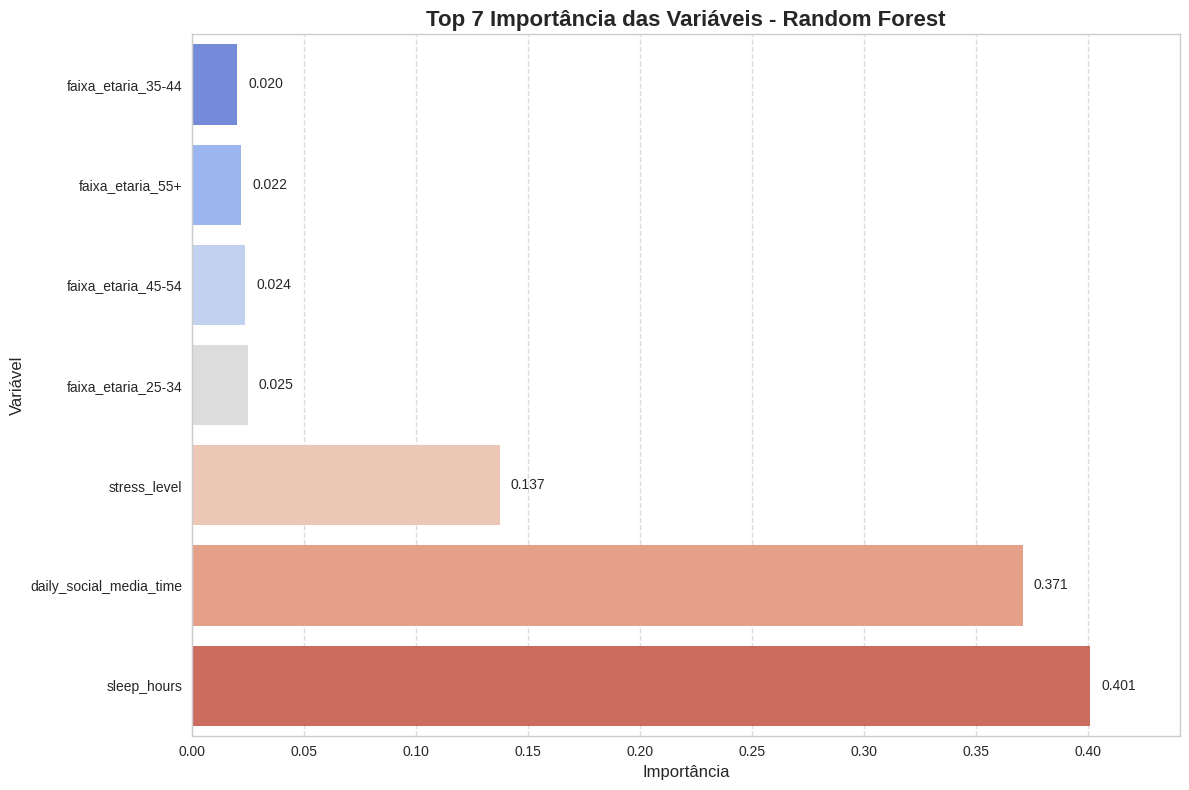

In [117]:
# Agrupando faixas etárias
bins = [0, 24, 34, 44, 54, 100]
labels = ['<25', '25-34', '35-44', '45-54', '55+']
df['faixa_etaria'] = pd.cut(df['age'], bins=bins, labels=labels)

# Seleção de features
features = ['daily_social_media_time', 'sleep_hours', 'stress_level', 'faixa_etaria']
X = df[features].copy()
y = df['actual_productivity_score']

X.fillna(X.mean(numeric_only=True), inplace=True)
y = y.loc[X.index]

# Codificação das categorias (get_dummies)
X = pd.get_dummies(X, columns=['faixa_etaria'], drop_first=True)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinamento do modelo Random Forest com X após dummies
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)

# Importância das variáveis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=True)

top_n = min(15, len(feature_importance))
feature_importance_top = feature_importance.tail(top_n)

# Gráfico de barras horizontal
plt.figure(figsize=(12, 8))
bars = sns.barplot(x='Importance', y='Feature', data=feature_importance_top, palette='coolwarm')

for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2,
             f'{width:.3f}', va='center', fontsize=10)

plt.title(f'Top {top_n} Importância das Variáveis - Random Forest', fontsize=16, weight='bold')
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Variável', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, feature_importance_top['Importance'].max() * 1.1)
plt.tight_layout()
plt.savefig("imgs_temp/melhor_modelo.png")
plt.show()


## 7. Validação Cruzada

In [118]:
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"MAE Validação Cruzada: {-cv_scores.mean():.2f} (± {cv_scores.std():.2f})")

MAE Validação Cruzada: 1.57 (± 0.01)


## 8. Visualização de Resultados

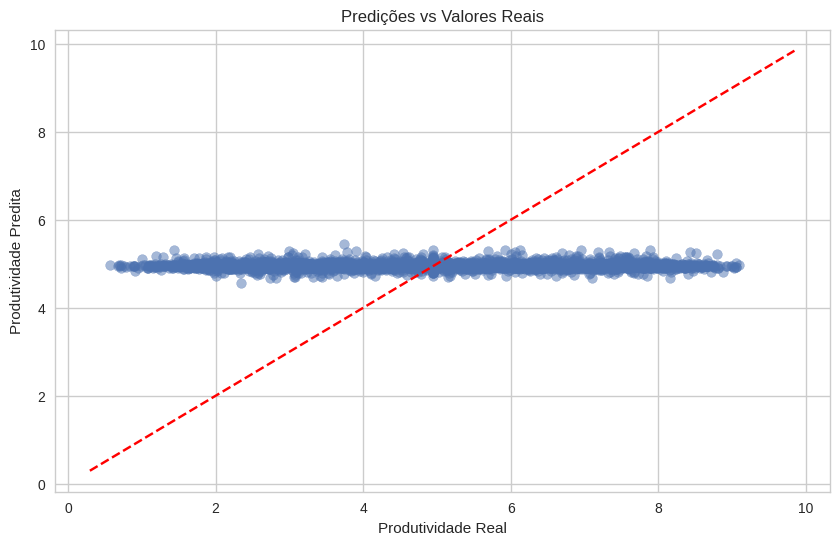

In [124]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel('Produtividade Real')
plt.ylabel('Produtividade Predita')
plt.title('Predições vs Valores Reais');
plt.savefig("imgs_temp/predicoes_valores_reais.png")

## 9. Exportação do Modelo

In [127]:
# Formata os números com 2 casas decimais
mae_baseline_str = f"{mae_baseline:.2f}"
r2_baseline_str = f"{r2_baseline:.2f}"
mae_lr_str = f"{mae_lr:.2f}"
r2_lr_str = f"{r2_lr:.2f}"
mae_rf_str = f"{mae_rf:.2f}"
r2_rf_str = f"{r2_rf:.2f}"
mae_xgb_str = f"{mae_xgb:.2f}"
r2_xgb_str = f"{r2_xgb:.2f}"
mae_cv_mean = -cv_scores.mean()
mae_cv_std = cv_scores.std()

df_head_html = df.head(3).to_html(index=False, classes='tabela')

results['MAE'] = results['MAE'].astype(float)
results['R²'] = results['R²'].astype(float)

# Formata os resultados para exibição no relatório
results['MAE'] = results['MAE'].map(lambda x: f"{x:.2f}")
results['R²'] = results['R²'].map(lambda x: f"{x:.2f}")
results_sorted = results.sort_values(by='MAE').reset_index(drop=True)

# Converte o DataFrame para tabela HTML, com classes para estilização
results_html = results_sorted.to_html(index=False, classes='tabela', border=0)

html_content = f"""
<html>
<head>
    <meta charset="utf-8" />
    <style>
        body {{ font-family: Arial, sans-serif; margin: 2em; color: #222; font-size: 12px; }}
        h1 {{ font-size: 16px; color: #333366; }}
        h2 {{ font-size: 14px; color: #333366; margin-top: 20px; }}
        h3 {{ color: #555555; font-size: 12px; margin-top: 10px; }}
        p {{ font-size: 12px; margin-top: 4px; }}
        table {{ border-collapse: collapse; width: 100%; margin: 20px 0; font-size: 12px; }}
        th {{
          background-color: #f2f2f2;
          color: #333;
          padding: 8px;
          border: 1px solid #ddd;
          text-align: center;
       }}
       td {{ padding: 8px; border: 1px solid #ddd; text-align: center; }}
       img {{ max-width: 470px; height: auto; margin-top: 10px; }}
       ul {{ list-style: none; padding-left: 0; font-size: 12px; }}
    </style>
</head>
<body>
  <h1>Relatório de Modelagem e Validação</h1>
  <p><strong>Objetivo:</strong> Construir e avaliar modelos preditivos</p>
  <p><strong>Dataset:</strong> processed_data.csv  </p>
  <p><strong>Autor:</strong> Flávia Souza e Vinicius Loeblein</p>

  <h2>1. Introdução</h2>
  <p>Este relatório apresenta a modelagem preditiva do dataset processado, com avaliação, comparação e interpretação dos modelos testados.</p>

  <h2>2. Visualização Inicial dos Dados</h2>
  <h3>2.1 Amostra dos Dados (3 primeiras linhas)</h3>
  {df_head_html}

  <h2>3. Modelagem</h2>

  <h3>3.1 Modelo Baseline (Média)</h3>
  <p>O modelo baseline prevê sempre a média dos valores de produtividade observados no conjunto de treino.</p>
  <table>
      <tr><th>Métrica</th><th>Valor</th></tr>
      <tr><td>MAE</td><td>{mae_baseline_str}</td></tr>
      <tr><td>R²</td><td>{r2_baseline_str}</td></tr>
  </table>

  <h3>3.2 Regressão Linear</h3>
  <p>A Regressão Linear é um modelo estatístico que tenta ajustar uma relação linear entre as variáveis preditoras e a variável alvo.</p>
  <table>
      <tr><th>Métrica</th><th>Valor</th></tr>
      <tr><td>MAE</td><td>{mae_lr_str}</td></tr>
      <tr><td>R²</td><td>{r2_lr_str}</td></tr>
  </table>

  <h3>3.3 Random Forest</h3>
  <p>Random Forest é um modelo de ensemble que combina múltiplas árvores de decisão para melhorar a precisão e evitar overfitting.</p>
  <table>
      <tr><th>Métrica</th><th>Valor</th></tr>
      <tr><td>MAE</td><td>{mae_rf_str}</td></tr>
      <tr><td>R²</td><td>{r2_rf_str}</td></tr>
  </table>

  <h3>3.4 XGBoost</h3>
  <p>XGBoost é um algoritmo de boosting eficiente e poderoso que combina múltiplos modelos fracos para criar um forte modelo preditivo.</p>
  <table>
      <tr><th>Métrica</th><th>Valor</th></tr>
      <tr><td>MAE</td><td>{mae_xgb_str}</td></tr>
      <tr><td>R²</td><td>{r2_xgb_str}</td></tr>
  </table>

  <h2>4. Comparação de Modelos</h2>
  <p>A tabela abaixo mostra a comparação dos modelos ordenada pelo MAE (menor é melhor):</p>
  {results_html}

  <h2>5. Interpretação do Melhor Modelo</h2>
  <p>O modelo Random Forest foi identificado como o melhor modelo com base nas métricas de avaliação. Para entender melhor o impacto das variáveis na predição, apresentamos abaixo o gráfico das <strong>Top {top_n} variáveis mais importantes</strong> segundo o modelo Random Forest.</p>
  <p>Este gráfico mostra quais features mais influenciam a capacidade do modelo em prever a produtividade, indicando os fatores-chave que devem ser priorizados para melhoria ou monitoramento.</p>
  <img src="imgs_temp/melhor_modelo.png" alt="Melhor Modelo">

  <h2>6. Predições vs Valores Reais</h2>
  <p>Este gráfico compara as predições do modelo Random Forest com os valores reais observados no conjunto de teste. Uma boa aproximação das predições aos valores reais indica que o modelo está performando bem na tarefa de previsão da produtividade.</p>
  <img src="imgs_temp/predicoes_valores_reais.png" alt="Predições vs Valores Reais" />

  <h2>7. Validação Cruzada do Random Forest</h2>
  <p>A validação cruzada é uma técnica para avaliar a robustez do modelo, dividindo os dados em múltiplos subsets para treinar e testar repetidamente.</p>
  <p>O MAE médio obtido na validação cruzada 5-fold do modelo Random Forest foi:</p>
  <table>
    <tr><th>Métrica</th><th>Valor</th></tr>
    <tr><td>MAE (média ± std)</td><td>{mae_cv_mean:.2f} ± {mae_cv_std:.2f}</td></tr>
  </table>
</body>
</html>
"""

# Gerar o PDF
HTML(string=html_content, base_url='.').write_pdf("rel_modelagem.pdf")
files.download("rel_modelagem.pdf")

DEBUG:fontTools.ttLib.ttFont:Reading 'maxp' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'maxp' table
DEBUG:fontTools.subset.timer:Took 0.002s to load 'maxp'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'maxp'
INFO:fontTools.subset:maxp pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'cmap' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'cmap' table
DEBUG:fontTools.ttLib.ttFont:Reading 'post' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'post' table
DEBUG:fontTools.subset.timer:Took 0.007s to load 'cmap'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'cmap'
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:fpgm dropped
INFO:fontTools.subset:prep dropped
INFO:fontTools.subset:cvt  dropped
INFO:fontTools.subset:kern dropped
DEBUG:fontTools.subset.timer:Took 0.000s to load 'post'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'post'
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:GPOS dropped
INFO:fontTools.subset:GSUB dropped
DEBUG:f

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>